This notebook shows how a cloud camera could be calibrated with the pyclamster and sun positions.

In [1]:
%matplotlib inline

import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import logging
import pyclamster
import pickle
import scipy
import scipy.misc
from skimage.feature import match_template

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

Load pickled coordinates for the first Hungriger Wolf camera

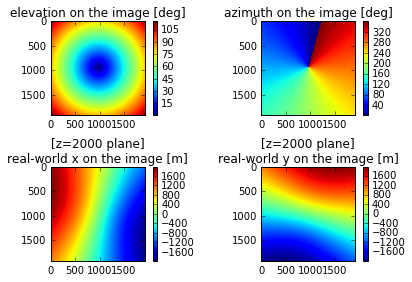

In [2]:
filename = "../examples/calibration/wolf-3-calibration.pk"
calibration = pickle.load(open(filename, 'rb'))
cal_coords = calibration.create_coordinates()
cal_coords.z = 2000
plt.subplot(221)
plt.title("elevation on the image [deg]")
plt.imshow(cal_coords.elevation*360/(2*np.pi))
plt.colorbar()
plt.subplot(222)
plt.title("azimuth on the image [deg]")
plt.imshow(cal_coords.azimuth*360/(2*np.pi))
plt.colorbar()
plt.subplot(223)
plt.title("[z=2000 plane]\nreal-world x on the image [m]")
plt.imshow(cal_coords.x)
plt.colorbar()
plt.subplot(224)
plt.title("[z=2000 plane]\nreal-world y on the image [m]")
plt.imshow(cal_coords.y)
plt.colorbar()
plt.tight_layout()

Set the paramters for the image clustering

In [3]:
base_folder = "../"
image_directory = os.path.join(base_folder, "examples", "images", "wolf")
trained_models = os.path.join(base_folder, "trained_models")

good_angle = 45
center = int(1920/2)
good_angle_dpi = int(np.round(1920 / 180 * good_angle))
denoising_ratio = 10
#all_images = glob.glob(os.path.join(image_directory, "Image_20160531_114000_UTCp1_*.jpg"))
#print(all_images)
all_images = [
    os.path.join(image_directory, "Image_20160531_114100_UTCp1_3.jpg"),
    os.path.join(image_directory, "Image_20160531_114100_UTCp1_4.jpg")]
kmeans = pickle.load(open(os.path.join(trained_models, "kmeans.pk"), "rb"))

Load image and preprocess it

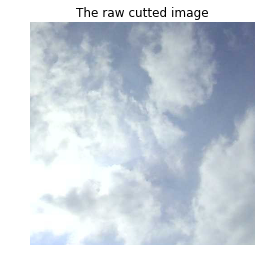

In [4]:
image = pyclamster.Image(all_images[0])
image.coordinates = cal_coords
cutted_image = image.cut([960, 960, 1460, 1460])
plt.title("The raw cutted image")
plt.imshow(cutted_image)
plt.axis('off')
image.data = pyclamster.clustering.preprocess.LCN(size=(25,25,3), scale=False).fit_transform(image.data)
image = image.cut([960, 960, 1460, 1460])
w, h, _ = original_shape = image.data.shape
raw_image = pyclamster.clustering.functions.rbDetection(image.data).reshape((w*h, -1))

Predict the labels with the trained model and convert it into a mask store

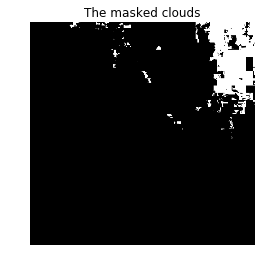

In [5]:
label = kmeans.predict(raw_image)
label.reshape((w, h), replace=True)
plt.title("The masked clouds")
plt.imshow(label.labels, cmap='gray')
plt.axis('off')
masks = label.getMaskStore()

Denoise the cloud mask and label the clouds

(499, 499, 3)


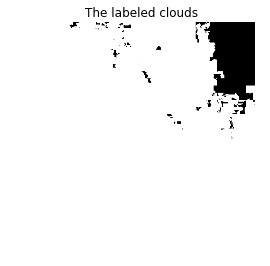

In [6]:
masks.denoise([0], 1000)
cloud_labels, _ = masks.labelMask([0,])
plt.title("The labeled clouds")
plt.imshow(cloud_labels.labels, cmap='gray')
plt.axis('off')
cloud_store = cloud_labels.getMaskStore()
clouds = [cloud_store.getCloud(cutted_image, [k,]) for k in cloud_store.masks.keys()]
cloud1 = cloud_store.cutMask(cutted_image, [1,])
print(cloud1.data.shape)

Load the second image and cutted 

(-0.5, 609.5, 609.5, -0.5)

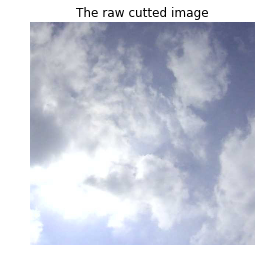

In [7]:
image = pyclamster.Image(all_images[1])
image = image.cut([850, 850, 1460, 1460])
plt.title("The raw cutted image")
plt.imshow(image)
plt.axis('off')

Move the cloud around to find the best matching point

(-0.5, 609.5, 609.5, -0.5)

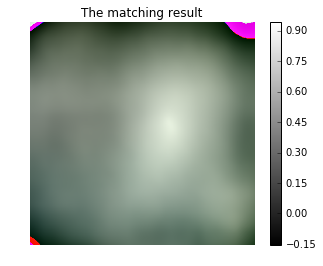

In [8]:
result = match_template(image.data, cloud1.data, pad_input=True, mode='reflect', constant_values=0)
plt.title("The matching result")
plt.imshow(result, cmap='gray')
plt.colorbar()
plt.axis('off')
#print(np.unravel_index(np.argmax(result), result.shape))

Example for SpatialCloud

In [9]:
image = pyclamster.Image(all_images[1])
image.coordinates = cal_coords            # Fake the second coordiante
image.crop([931, 981, 1430, 1480])
cloud2 = pyclamster.matching.Cloud(image)

[[-1401.617156107747 -1334.3073767085314 -1276.6437071153853 ...,
  244.29018841139884 243.49562734678935 242.70424838419186]
 [-1366.624779100958 -1318.590122630382 -1275.5090296075684 ...,
  246.36504187218526 245.5588253104024 244.75587279429612]
 [-1329.382494985241 -1294.4937707853364 -1262.3030773602216 ...,
  248.475082387997 247.65692658059933 246.84211951238058]
 ..., 
 [-54.66835743421213 -54.69926079816118 -54.73008986979206 ...,
  -56.905488940959 -56.87080737521528 -56.83589020320243]
 [-54.50759399208695 -54.53835198118149 -54.569035628994484 ...,
  -56.67450237584549 -56.63971618665418 -56.60469478682678]
 [-54.347326666764594 -54.37794010835468 -54.408479160699066 ...,
  -56.44454632105167 -56.40965674339043 -56.37453235023536]]


(-0.5, 498.5, 498.5, -0.5)

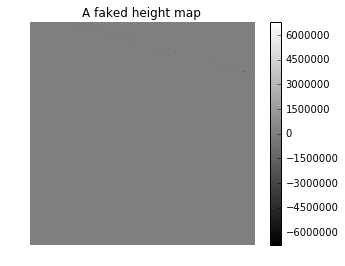

In [10]:
sCloud = pyclamster.matching.SpatialCloud(pyclamster.matching.Cloud(cloud1), cloud2)
position = sCloud._calc_position()
print(position[2])
plt.title("A faked height map")
plt.imshow(position[2], cmap='gray')
plt.colorbar()
plt.axis('off')